In [66]:
using JLD2
using FourierFlows
using CairoMakie
using AbstractFFTs
using Printf
using Interpolations
include("./AnalysisUtils.jl")

mapfilter_snapshots (generic function with 1 method)

In [84]:
#run_directory = "/vast/nad9961/mrsw/2091922"
#fourier_directory = "/scratch/nad9961/rsw_fourier/2109555"

#run_directory = "/vast/nad9961/swqg/2126017"
#fourier_directory = "/scratch/nad9961/swqg_fourier/2133652/"

#run_directory = "/vast/nad9961/swqg/2133654"
#fourier_directory = "/scratch/nad9961/swqg_fourier/2141274/"

run_directory = "/vast/nad9961/swqg/2192791/"
fourier_directory = "/scratch/nad9961/swqg_fourier/2199948"

"/scratch/nad9961/swqg_fourier/2199948"

In [85]:
Nsnaps = count_key_snapshots(run_directory, "qgsw")
println(Nsnaps)
t, sol = load_key_snapshot(run_directory, "qgsw", Nsnaps)
params = read_swqg_params(run_directory, "qgsw")
grid = TwoDGrid(; nx=512, Lx=2π)
ω_size = 4529
f0 = 3.0
Cg = 1.0
qh = sol
ψh = @. -qh / (grid.Krsq + params.Kd2)
uh = @. -1im * grid.l  * ψh
vh = @.  1im * grid.kr * ψh
u = irfft(uh, grid.nx)
v = irfft(vh, grid.nx)
sqrt.(sum(u.^2 + v.^2)/grid.nx/grid.ny)

32598


0.08331486096422423

In [92]:
refine_factor = 1
UU_corr = zeros(Complex{Float64}, ω_size, 2 * grid.nkr * refine_factor)
UV_corr = zeros(Complex{Float64}, ω_size, 2 * grid.nkr * refine_factor)
VV_corr = zeros(Complex{Float64}, ω_size, 2 * grid.nkr * refine_factor)
D_11 = zeros(Float64, grid.nkr, grid.nl)
D_12 = zeros(Float64, grid.nkr, grid.nl)
D_22 = zeros(Float64, grid.nkr, grid.nl)
f0 = 3.0
c = 1.0
ω = @. sqrt(f0^2 + c^2*grid.Krsq)
Cg_x = @. c * grid.kr / ω
Cg_y = @. c * grid.l / ω
α = 1.0
for file_idx=1:172
    println(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, floor(Int, (file_idx-1)/4 + 1), file_idx))
    file = jldopen(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, floor(Int, (file_idx-1)/4 + 1), file_idx))
    k = file["k"]
    t = file["t"] / α
    #ugt = α*file["ugt"]
    #vgt = α*file["vgt"]
    ψt = α * file["ψt"]
    T = t[end] - t[1]
    dt = t[2] - t[1]
    Nω = length(t)
    ωs = fftshift(fftfreq(length(t), 1/dt) * 2π)
    σ = @. (-k * Cg_x - grid.l * Cg_y)
    
    norm_factor = T / Nω^2 * (2π)^2 / grid.nx^2 / grid.ny^2
    #V_11 = fftshift(real.(conj(ugt) .* ugt)) * norm_factor
    #V_12 = fftshift(real.(conj(ugt) .* vgt)) * norm_factor
    #V_22 = fftshift(real.(conj(vgt) .* vgt)) * norm_factor
    #@views V_11[ωs .> f0*α, :] .= 0
    #@views V_12[ωs .> f0*α, :] .= 0
    #@views V_22[ωs .> f0*α, :] .= 0
    C_hat = fftshift(real.(conj.(ψt) .* ψt)) * norm_factor
    V_11 = @.  grid.l * grid.l * C_hat
    V_12 = @. -k * grid.l * C_hat
    V_22 = @.  k * k * C_hat

    println(maximum(abs.(ωs)))
    println(maximum(abs.(σ)))
    v11_itp = extrapolate(scale(interpolate(V_11, BSpline(Linear())), ωs, (-grid.nkr+1):(grid.nkr-2)), 0)
    v12_itp = extrapolate(scale(interpolate(V_12, BSpline(Linear())), ωs, (-grid.nkr+1):(grid.nkr-2)), 0)
    v22_itp = extrapolate(scale(interpolate(V_22, BSpline(Linear())), ωs, (-grid.nkr+1):(grid.nkr-2)), 0)
    
    D_11 += k      .* k      .* v11_itp.(σ, grid.l)
    D_12 += k      .* grid.l .* v12_itp.(σ, grid.l)
    D_22 += grid.l .* grid.l .* v22_itp.(σ, grid.l)

    #println(itp.(σ, grid.l))
    #K = @. sqrt(grid.l[:]^2 + k^2)
    #K_idx = @. floor(Int, K * refine_factor + 1)
    
    #@view(UU_corr[:, K_idx]) .+= real.(conj.(ugt) .* ugt)
    #@view(UV_corr[:, K_idx]) .+= real.(conj.(ugt) .* vgt)
    #@view(VV_corr[:, K_idx]) .+= real.(conj.(vgt) .* vgt)
    println(file_idx)
    close(file)
end

/scratch/nad9961/swqg_fourier/2199948/1/radial_data_k=001.jld2
514.7027499987695
255.98242368528392
1
/scratch/nad9961/swqg_fourier/2199948/1/radial_data_k=002.jld2
514.7027499987695
255.9843769367922
2
/scratch/nad9961/swqg_fourier/2199948/1/radial_data_k=003.jld2
514.7027499987695
255.99023660189502
3
/scratch/nad9961/swqg_fourier/2199948/1/radial_data_k=004.jld2


LoadError: InterruptException:

In [90]:
D_11_true = grid.kr .* grid.kr/(2π)^2 .* D_11
D_12_true = grid.kr .* grid.l /(2π)^2 .* D_12
D_22_true = grid.l  .* grid.l /(2π)^2 .* D_22
D_11_p = @. (grid.kr^2 .* D_11_true + 2 * grid.kr * grid.l * D_12_true + grid.l^2 * D_22_true) * grid.invKrsq

257×512 Matrix{Float64}:
 0.0          2.97395e-7  7.41461e-8   …  8.05282e-8   1.79298e-7
 1.20175e-5   1.83072e-6  6.14176e-8      6.98959e-8   1.87376e-6
 1.16486e-6   2.94296e-8  3.33085e-10     5.54639e-10  4.88554e-8
 1.69318e-6   1.83794e-7  2.09481e-7      2.47881e-7   9.45217e-8
 1.85866e-8   8.38046e-7  9.56954e-10     4.28908e-9   1.43274e-7
 1.553e-7     1.12986e-6  1.5911e-9    …  1.79396e-9   1.44276e-7
 2.74229e-7   9.35557e-7  1.70197e-8      7.98276e-9   2.55648e-7
 1.41324e-7   7.72184e-7  3.13114e-8      1.39601e-8   3.88387e-7
 2.07256e-7   8.63095e-7  4.77618e-8      2.93766e-8   4.69844e-7
 2.98299e-7   1.02972e-6  4.42236e-8      6.95748e-8   5.68269e-7
 5.57899e-7   1.25458e-6  5.15827e-8   …  1.23353e-7   6.98397e-7
 8.4981e-7    1.54093e-6  1.19164e-7      1.85009e-7   8.55901e-7
 1.17346e-6   1.89028e-6  4.08642e-7      1.10466e-7   1.04138e-6
 ⋮                                     ⋱  ⋮            
 0.000396448  0.00312938  0.02017      …  0.00578391   0.0003

[8.272191469753033e-6, 0.0, 0.0]


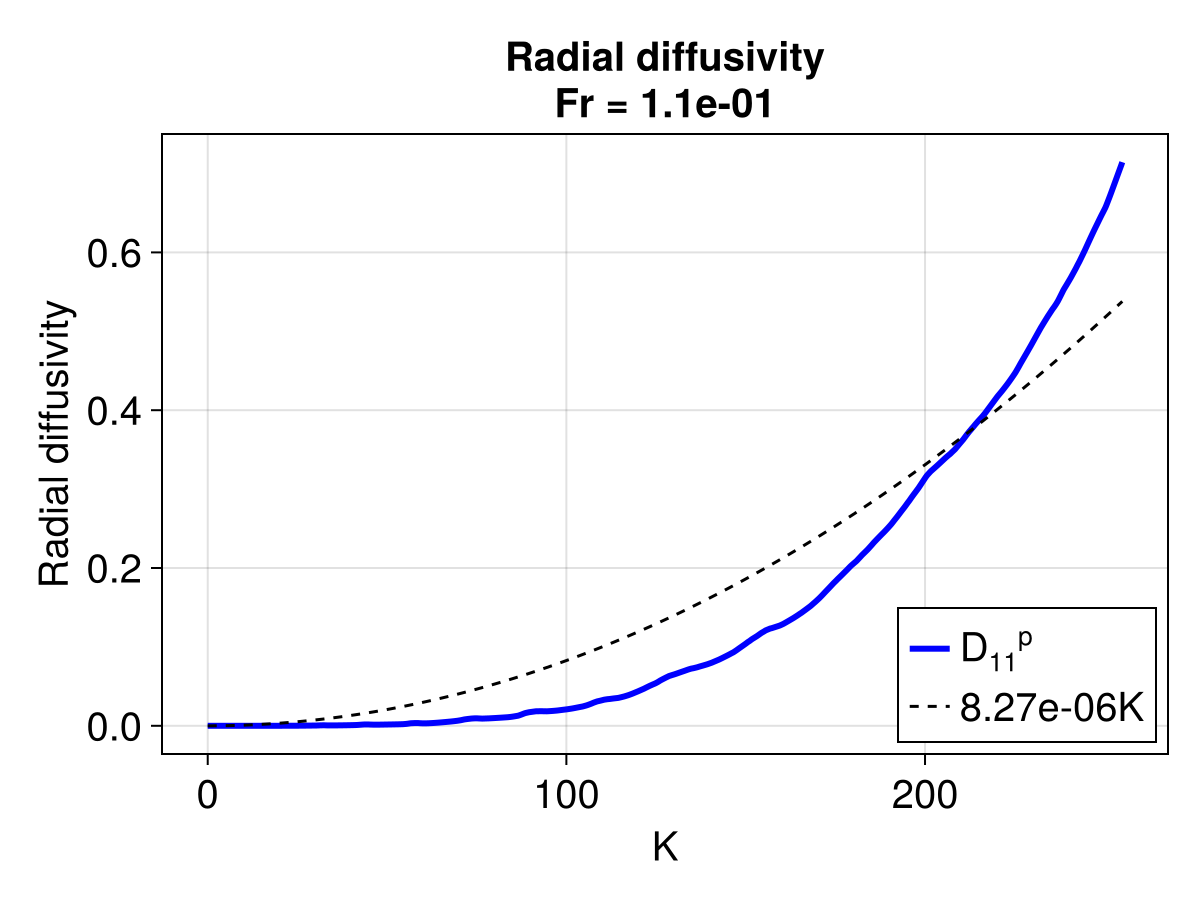

In [91]:
using LsqFit
ρ, D_11_p_R = FourierFlows.radialspectrum(D_11_p, grid)
m(k, p) = p[1]*k.^2# .+ p[2]*k# .+ p[3]
p0 = [2e-8, 0, 0]
fit = curve_fit(m, ρ, D_11_p_R[:], p0)
println(fit.param)
fig = Figure(fontsize=20)
ax = Axis(fig[1,1]; title=@sprintf("Radial diffusivity\nFr = %0.1e", α * 1.1e-1), ylabel="Radial diffusivity", xlabel="K")
lines!(ax, ρ, D_11_p_R[:], label=rich("D", subscript("11"), superscript("p")), color=:blue, linewidth=3)
lines!(ax, ρ, m(ρ, fit.param), label=rich(@sprintf("%0.2eK", fit.param[1])), linestyle=:dash, color=:black)
axislegend(ax, position=:rb)
save("radial_diffusivity.eps", fig)
fig

In [10]:
D_11

257×512 Matrix{Float64}:
 39148.0          15.5565      …  0.00545226  0.104921    11.0715
     0.026348      0.00280695     9.84864e-7  6.32781e-6   0.00241729
     0.000291923   1.41814e-5     5.32508e-9  2.59398e-7   1.32691e-5
     8.37795e-6    2.99629e-6     4.51173e-9  7.39027e-8   3.91782e-6
     1.04074e-6    2.69445e-6     2.76434e-9  6.20379e-8   2.63384e-6
     7.02787e-6    3.17755e-7  …  3.29225e-8  6.97631e-8   5.34797e-7
     1.58558e-6    7.56475e-7     1.20898e-8  6.35241e-8   1.04043e-7
     1.53515e-6    1.55653e-6     4.7237e-8   2.11481e-7   9.51165e-8
     1.13683e-6    1.93575e-6     1.84813e-7  7.59666e-7   1.47488e-7
     7.98796e-7    2.11754e-6     6.07227e-8  8.00955e-7   1.74409e-7
     7.94624e-7    2.16767e-6  …  1.1062e-6   5.74623e-7   1.7843e-7
     7.93458e-7    2.1302e-6      1.84231e-7  5.72875e-7   1.53377e-7
     7.53442e-7    2.05019e-6     3.40634e-7  8.89881e-7   1.33707e-7
     ⋮                         ⋱              ⋮           
     2.7608

In [6]:
file = jldopen(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, 1,1))
k = file["k"]
t = file["t"]
T = t[end] - t[1]
dt = t[2] - t[1]
Nω = length(t)
ωs = fftshift(fftfreq(length(t), 1/dt) * 2π)
σ = @. -k * Cg_x - grid.l * Cg_y

norm_factor = T / Nω^2 * (2π)^2 / grid.nx / grid.ny

5.6371557466791425e-11

In [236]:
Lx = 2π
Ly = 4π
Nx = 57
Ny = 32
x = (0:(Nx-1))/Nx * Lx
y = (0:(Ny-1))/Ny * Ly
dx = Lx/Nx
dy = Ly/Ny
test_signal = sin.(x .+ y')
th = rfft(test_signal)
Nkr = mod(Nx, 2) == 0 ? Int(Nx/2) : Int((Nx-1)/2)
println(sum(abs2.(test_signal) * dx * dy))

sum_val = sum(abs2, th[1,:])
sum_val += 2 * sum(abs2, th[2:Nkr-1,:])
sum_val += sum(abs2, th[Nkr, :])
println(sum_val * Lx/Nx^2 * Ly/Ny^2)

39.478417604357446
39.47841760435743


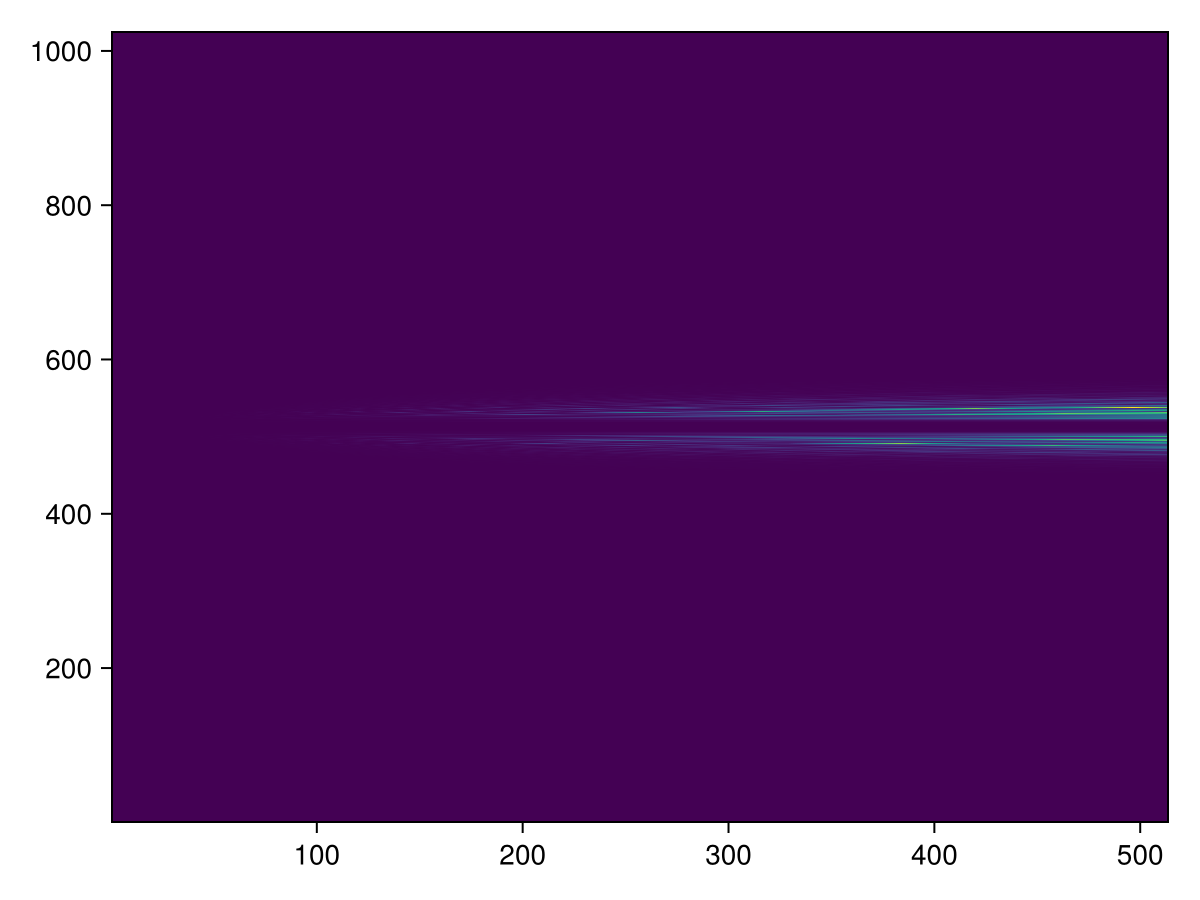

In [16]:
D_11 = 0
D_12 = 0
D_13 = 0

heatmap(fftshift(abs.(D_11_p), 2))

In [85]:
A = zeros(3, 3)
idx = [2, 2, 1]
vec = [1., 1., 1.]
@view(A[:, idx]) .+= vec
A

3×3 Matrix{Float64}:
 1.0  2.0  0.0
 1.0  2.0  0.0
 1.0  2.0  0.0

In [144]:
UV_corr

5094×1026 Matrix{ComplexF64}:
 0.0+0.0im       1526.78+2349.1im       …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im       382.886+594.264im         0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im    -0.0165674+0.00794551im      0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im    0.00247922-0.00497487im      0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im   -0.00724335+0.0303254im       0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im    -0.0133524+0.000746689im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im    0.00461994-0.00714325im      0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im    0.00277377+0.0060732im       0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im    0.00195566+0.00273131im      0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  -0.000713461-0.000380482im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im    0.00125855+0.000150831im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  -0.000883809+0.00173753im      0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  -0.000624352-0.000920889im     0.0+0.0im  0.0+0.0im  0.0+0

In [149]:
file = jldopen(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, 4, 16))
k = file["k"]
K = @. sqrt(grid.l[:]^2 + k^2)
K_idx = @. floor(Int, K * refine_factor + 1)
ugt = file["ugt"]
vgt = file["vgt"]

5094×1024 Matrix{ComplexF64}:
   -7.41555-131.809im      -23.4615+79.4254im    …     -18.2973-48.9603im
    3.65619+64.495im        11.5717-38.271im            9.10185+24.8465im
  -0.406452+1.32038im      0.490395-1.83548im          0.242002-0.596495im
   0.650017+0.873297im    -0.403432+0.719335im        -0.255023+0.653261im
  -0.549699-0.772827im   -0.0564758-0.307462im        -0.188927-0.567742im
   0.595055+0.323978im     0.186708-0.140905im   …     0.456354+0.264967im
  -0.632934-0.871232im    0.0183284+0.458984im         -0.23587+0.0430532im
   0.613808+0.568535im    -0.215241-0.18453im         -0.059603-0.167758im
  -0.191324-0.0538313im   0.0918095+0.0112416im        0.240856+0.164108im
 -0.0766079+0.0316376im  0.00157965-0.0465645im       -0.237175-0.143083im
 -0.0631021+0.175622im     0.022483+0.154797im   …     0.170913-0.00846211im
  -0.078558-0.224553im    0.0443085-0.265im          -0.0761854+0.0715772im
   0.141093-0.111902im    -0.108072+0.196092im       -0.0365005+0.05

In [152]:
conj.(vgt) .* ugt

5094×1024 Matrix{ComplexF64}:
 -0.0+0.0im      -457.256+1.42109e-14im  …      182.127+2.84217e-14im
  0.0+0.0im      -106.571+5.11591e-13im         46.6795-1.3376e-12im
  0.0-0.0im     -0.240631-5.57887e-15im       0.0276247-6.25541e-15im
  0.0+0.0im    -0.0453467+4.996e-16im         0.0327857+1.71564e-15im
 -0.0+0.0im   -0.00651483-1.0018e-16im        0.0238683-6.9042e-16im
  0.0+0.0im   -0.00364762-1.14925e-17im  …    0.0185644+1.94289e-16im
 -0.0+0.0im    -0.0140668+3.58871e-17im      0.00383254+3.14419e-18im
  0.0+0.0im   -0.00535865-1.25767e-17im      0.00211302-3.31766e-17im
 -0.0+0.0im  -0.000570358-6.64074e-19im      0.00566288+2.77556e-17im
  0.0-0.0im  -0.000144716-1.58056e-18im      0.00511499-1.34441e-17im
  0.0-0.0im   -0.00163118+3.27971e-18im  …   0.00195219+2.6834e-18im
 -0.0+0.0im   -0.00481254-6.50521e-19im     0.000728501+4.39102e-18im
  0.0+0.0im    -0.0033421+2.60209e-18im      0.00029553+1.0842e-18im
     ⋮                                   ⋱  
  0.0+0.0im  -0.000

In [45]:
for α = [1.0]#, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
    f0 = 3.0
    c = 1.0
    ω = @. sqrt(f0^2 + c^2*grid.Krsq)
    Cg_x = @. c * grid.kr / ω
    Cg_y = @. c * grid.l / ω
    file = jldopen(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, 1, 2))
    k = file["k"]
    t = file["t"]/α
    ugt = α*file["ugt"]
    vgt = α*file["vgt"]
    T = (t[end] - t[1])
    dt = (t[2] - t[1])
    Nω = length(t)
    ωs = fftshift(fftfreq(length(t), 1/dt) * 2π)
    σ = @. -k * Cg_x - grid.l * Cg_y
    
    norm_factor = T / Nω^2 * (2π)^2 / grid.nx^2 / grid.ny^2
    V_11 = fftshift(real.(conj(ugt) .* ugt)) * norm_factor
    V_12 = fftshift(real.(conj(ugt) .* vgt)) * norm_factor
    V_22 = fftshift(real.(conj(vgt) .* vgt)) * norm_factor
    @views V_11[ωs .> f0, :] .= 0
    @views V_12[ωs .> f0, :] .= 0
    @views V_22[ωs .> f0, :] .= 0
    
    v11_itp = extrapolate(scale(interpolate(V_11, BSpline(Linear())), ωs, (-grid.nkr+1):(grid.nkr-2)), 0)
    v12_itp = extrapolate(scale(interpolate(V_12, BSpline(Linear())), ωs, (-grid.nkr+1):(grid.nkr-2)), 0)
    v22_itp = extrapolate(scale(interpolate(V_22, BSpline(Linear())), ωs, (-grid.nkr+1):(grid.nkr-2)), 0)
    
    D_11 = k      .* k      .* v11_itp.(σ, grid.l)
    D_12 += k      .* grid.l .* v12_itp.(σ, grid.l)
    D_22 += grid.l .* grid.l .* v22_itp.(σ, grid.l)
    D_11_true = grid.kr .* grid.kr/(2π)^2 .* D_11
    D_12_true = grid.kr .* grid.l /(2π)^2 .* D_12
    D_22_true = grid.l  .* grid.l /(2π)^2 .* D_22
    D_11_p = @. (grid.kr^2 .* D_11_true + 2 * grid.kr * grid.l * D_12_true + grid.l^2 * D_22_true) * grid.invKrsq
    ρ, D_11_r = FourierFlows.radialspectrum(D_11_p, grid)
    m(k, p) = p[1]*k.^2
    p0 = [2e-8]
    fit = curve_fit(m, ρ, D_11_r[:], p0)
    println(@sprintf("α: %0.2e\tb: %0.2e", α, fit.param[1]))
end

α: 1.00e+00	b: -1.66e-03


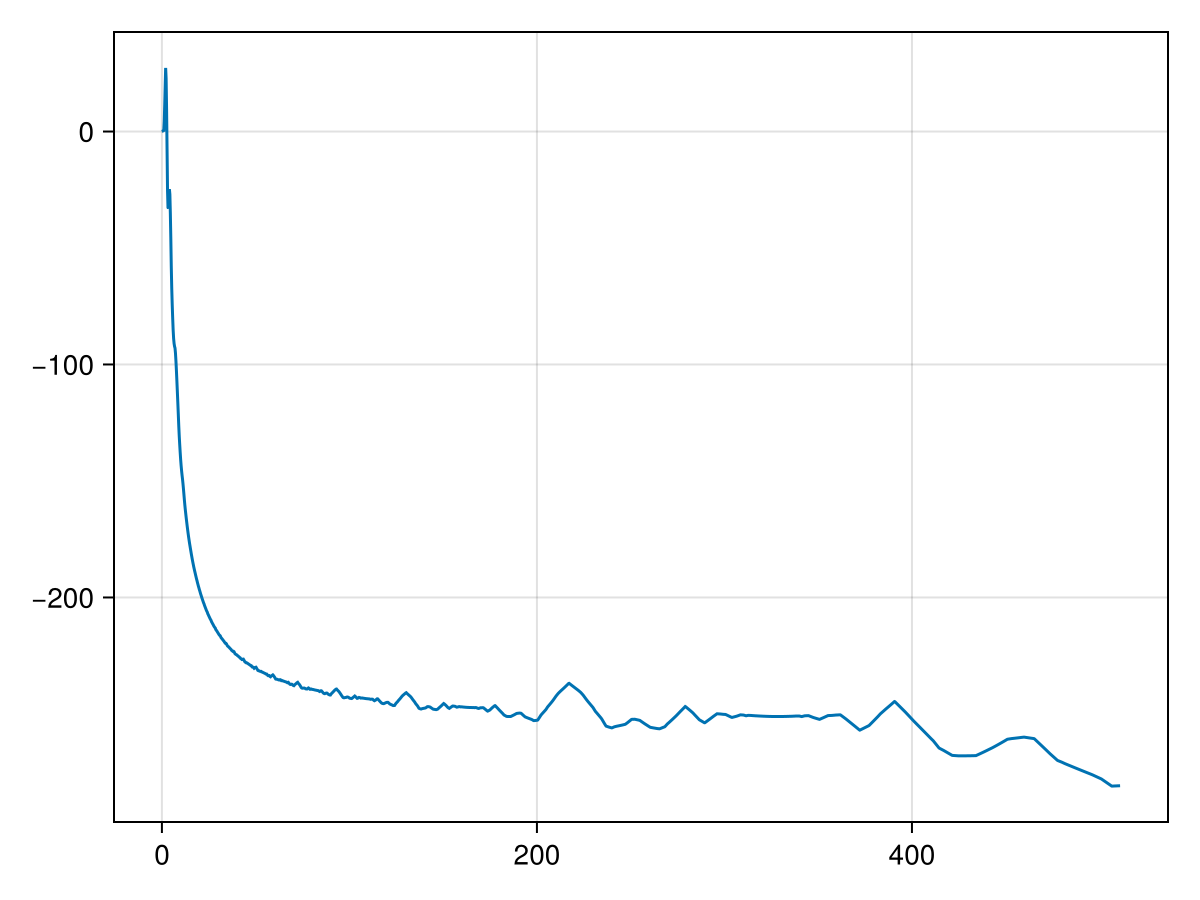

In [46]:
lines(ρ, D_11_r[:])

In [51]:
α = 1.0
ugt = α*file["ugt"]
vgt = α*file["vgt"]
real.(conj.(ugt) .* vgt)[45, 46]

-36214.98537824153

In [108]:
Nsnaps = 1024
α = 2.0
dt = 0.1 / α

t = ((0:(Nsnaps-1))*dt) / α
y = α * sin.(5 * t)
yh = fft(y)

println(sum(abs2.(y)) * dt)
println(sum(abs2.(yh)) * dt / Nsnaps)

102.74560982058978
102.74560982058986


In [27]:
file = jldopen(@sprintf("%s/%d/radial_data_k=%03d.jld2", fourier_directory, 40, 160))
k = file["k"]
t = file["t"]
#ugt = α*file["ugt"]
#vgt = α*file["vgt"]
ψt = file["ψt"]
T = t[end] - t[1]
dt = t[2] - t[1]
Nω = length(t)
ωs = fftshift(fftfreq(length(t), 1/dt) * 2π)
σ = @. -k * Cg_x - grid.l * Cg_y

norm_factor = T / Nω^2 * (2π)^2 / grid.nx^2 / grid.ny^2
#V_11 = fftshift(real.(conj(ugt) .* ugt)) * norm_factor
#V_12 = fftshift(real.(conj(ugt) .* vgt)) * norm_factor
#V_22 = fftshift(real.(conj(vgt) .* vgt)) * norm_factor
#@views V_11[ωs .> f0*α, :] .= 0
#@views V_12[ωs .> f0*α, :] .= 0
#@views V_22[ωs .> f0*α, :] .= 0
C_hat = fftshift(real.(conj.(ψt) .* ψt)) * norm_factor

4528×512 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

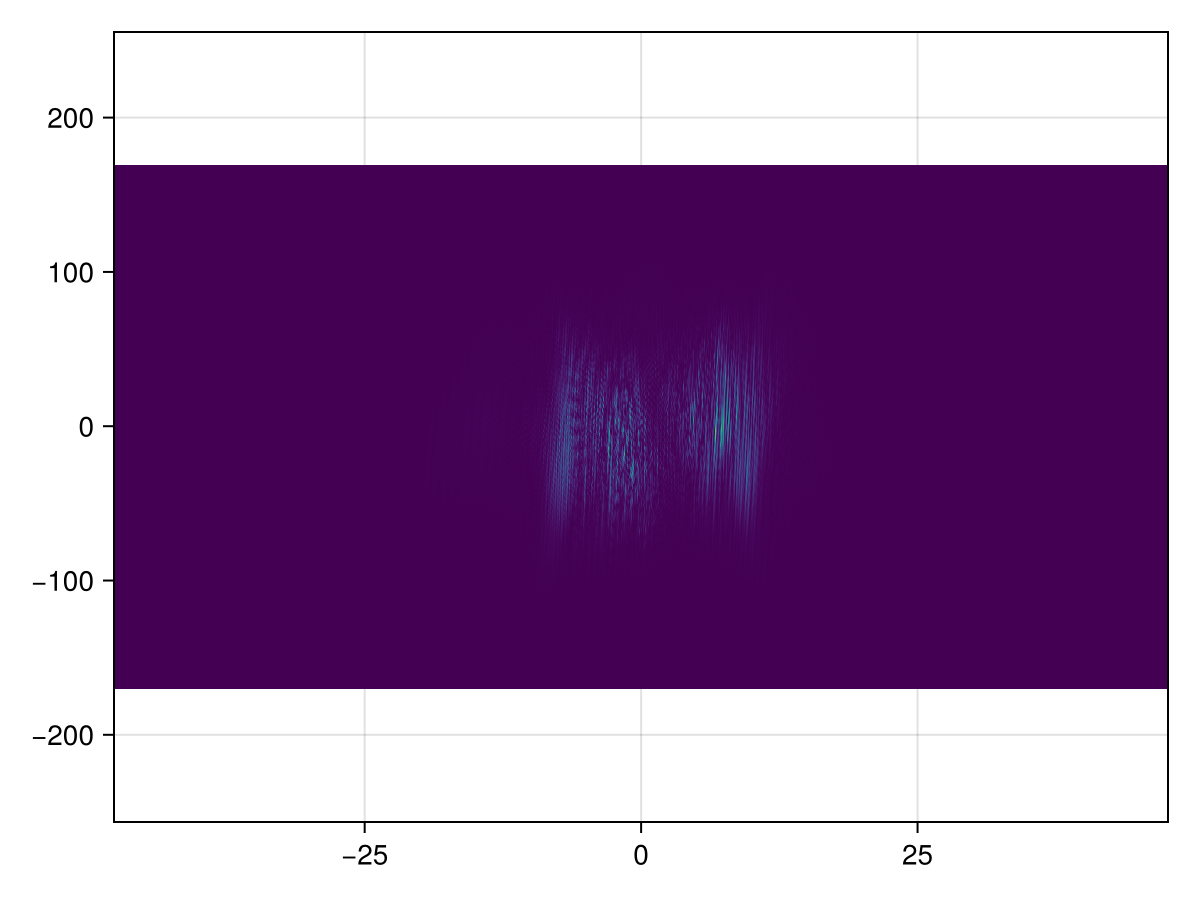

In [28]:
heatmap(ωs, fftshift(grid.l[:]), (replace(C_hat, 0.0=>NaN)))

In [15]:
C_hat

4528×512 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [95]:
grid = OneDGrid(; nx=256, Lx=2π)
Nt = 1024
T = 10π
dt = T/Nt
t = (0:(Nt-1)) * dt


0.0:0.030679615757712823:31.38524692014022